In [4]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import numpy as np
import time
# import lightgbm as lgb

from sklearn.model_selection import GroupKFold
from sklearn import metrics

In [22]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [27]:
# import lightgbm as lgb

# import lightgbm as lgb
# print(lgb.__version__)


## Data loading and overview

In [ ]:
# path = '../input/ventilator-pressure-prediction'
# train = pd.read_csv(os.path.join(path, 'train.csv'))
# test = pd.read_csv(os.path.join(path, 'test.csv'))
# sub = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

In [8]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [9]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


The dataset is quite large - more than 6 mln rows. There are 2 categorical features (R and C), the id of a row, the id of a breath, timestamp and continuous variables.

In [10]:
print(set(test['breath_id'].unique()).intersection(set(train['breath_id'].unique())))
print(set(train['breath_id'].unique()).intersection(set(test['breath_id'].unique())))

set()
set()


Here is a very **important** point:
The breath ids in train and test don't overlap! This means we should use GroupKFold validation using this variable.

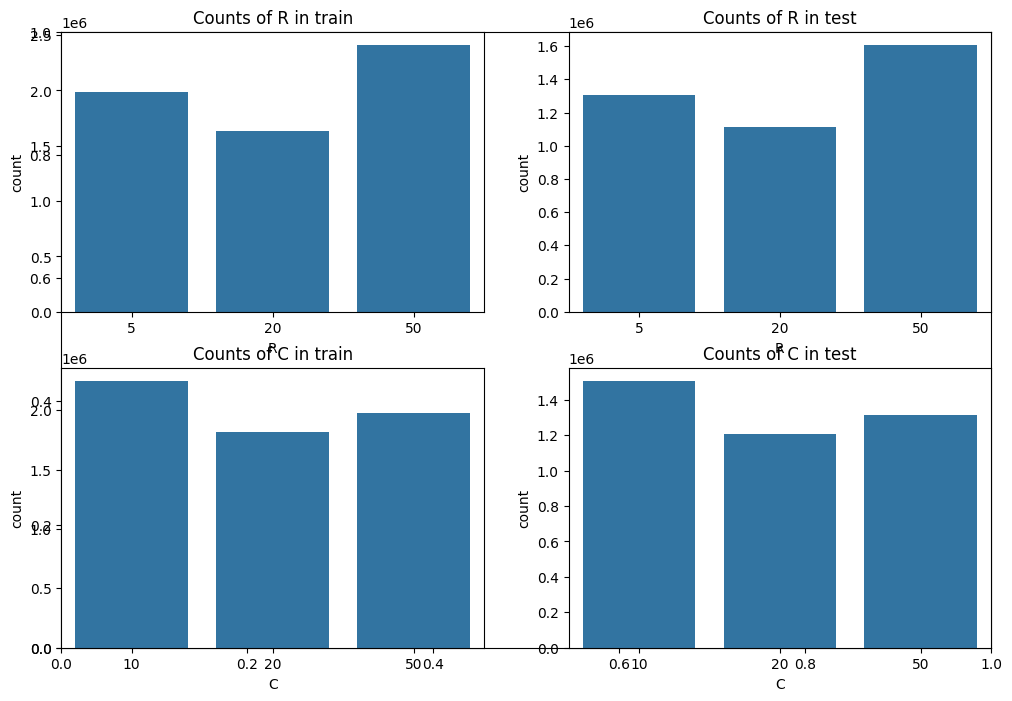

In [11]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=train)
plt.title('Counts of R in train');
plt.subplot(2, 2, 2)
sns.countplot(x='R', data=test)
plt.title('Counts of R in test');
plt.subplot(2, 2, 3)
sns.countplot(x='C', data=train)
plt.title('Counts of C in train');
plt.subplot(2, 2, 4)
sns.countplot(x='C', data=test)
plt.title('Counts of C in test');

`R` and `C` categorical variables have a similar distribution in train and test data.

Now, let's have a look at one of the series in the data.

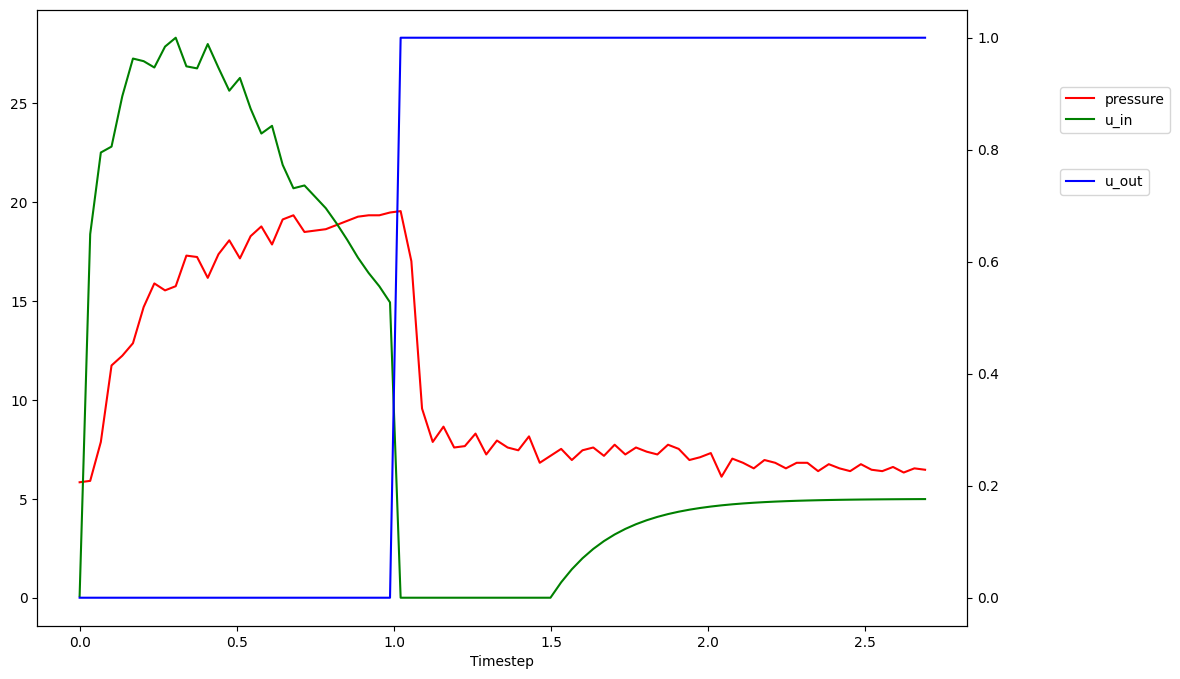

In [12]:
fig, ax1 = plt.subplots(figsize = (12, 8))

breath_1 = train.loc[train['breath_id'] == 1]
ax2 = ax1.twinx()

ax1.plot(breath_1['time_step'], breath_1['pressure'], 'r-', label='pressure')
ax1.plot(breath_1['time_step'], breath_1['u_in'], 'g-', label='u_in')
ax2.plot(breath_1['time_step'], breath_1['u_out'], 'b-', label='u_out')

ax1.set_xlabel('Timestep')

ax1.legend(loc=(1.1, 0.8))
ax2.legend(loc=(1.1, 0.7))
plt.show()

This is quite interesting: we can see that at first the `pressure` (our target) is rising and then, after the `u_out` becomes equal to 1, it has an abrupt drop. I think it would be useful to create new features based on the behavior of these features.

## Feature engineering

In [13]:
# rewritten calculation of lag features from this notebook: https://www.kaggle.com/patrick0302/add-lag-u-in-as-new-feat
# some of ideas from this notebook: https://www.kaggle.com/mst8823/google-brain-lightgbm-baseline
train['last_value_u_in'] = train.groupby('breath_id')['u_in'].transform('last')
train['u_in_lag1'] = train.groupby('breath_id')['u_in'].shift(1)
train['u_out_lag1'] = train.groupby('breath_id')['u_out'].shift(1)
train['u_in_lag_back1'] = train.groupby('breath_id')['u_in'].shift(-1)
train['u_out_lag_back1'] = train.groupby('breath_id')['u_out'].shift(-1)
train['u_in_lag2'] = train.groupby('breath_id')['u_in'].shift(2)
train['u_out_lag2'] = train.groupby('breath_id')['u_out'].shift(2)
train['u_in_lag_back2'] = train.groupby('breath_id')['u_in'].shift(-2)
train['u_out_lag_back2'] = train.groupby('breath_id')['u_out'].shift(-2)
train['u_in_lag3'] = train.groupby('breath_id')['u_in'].shift(3)
train['u_out_lag3'] = train.groupby('breath_id')['u_out'].shift(3)
train['u_in_lag_back3'] = train.groupby('breath_id')['u_in'].shift(-3)
train['u_out_lag_back3'] = train.groupby('breath_id')['u_out'].shift(-3)
train = train.fillna(0)


train['R__C'] = train["R"].astype(str) + '__' + train["C"].astype(str)

# max value of u_in and u_out for each breath
train['breath_id__u_in__max'] = train.groupby(['breath_id'])['u_in'].transform('max')
train['breath_id__u_out__max'] = train.groupby(['breath_id'])['u_out'].transform('max')

# difference between consequitive values
train['u_in_diff1'] = train['u_in'] - train['u_in_lag1']
train['u_out_diff1'] = train['u_out'] - train['u_out_lag1']
train['u_in_diff2'] = train['u_in'] - train['u_in_lag2']
train['u_out_diff2'] = train['u_out'] - train['u_out_lag2']
# from here: https://www.kaggle.com/yasufuminakama/ventilator-pressure-lstm-starter
train.loc[train['time_step'] == 0, 'u_in_diff'] = 0
train.loc[train['time_step'] == 0, 'u_out_diff'] = 0

# difference between the current value of u_in and the max value within the breath
train['breath_id__u_in__diffmax'] = train.groupby(['breath_id'])['u_in'].transform('max') - train['u_in']
train['breath_id__u_in__diffmean'] = train.groupby(['breath_id'])['u_in'].transform('mean') - train['u_in']

# OHE
train = train.merge(pd.get_dummies(train['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
train = train.merge(pd.get_dummies(train['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
train = train.merge(pd.get_dummies(train['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/273974
train['u_in_cumsum'] = train.groupby(['breath_id'])['u_in'].cumsum()
train['time_step_cumsum'] = train.groupby(['breath_id'])['time_step'].cumsum()

In [14]:
# all the same for the test data
test['last_value_u_in'] = test.groupby('breath_id')['u_in'].transform('last')
test['u_in_lag1'] = test.groupby('breath_id')['u_in'].shift(1)
test['u_out_lag1'] = test.groupby('breath_id')['u_out'].shift(1)
test['u_in_lag_back1'] = test.groupby('breath_id')['u_in'].shift(-1)
test['u_out_lag_back1'] = test.groupby('breath_id')['u_out'].shift(-1)
test['u_in_lag2'] = test.groupby('breath_id')['u_in'].shift(2)
test['u_out_lag2'] = test.groupby('breath_id')['u_out'].shift(2)
test['u_in_lag_back2'] = test.groupby('breath_id')['u_in'].shift(-2)
test['u_out_lag_back2'] = test.groupby('breath_id')['u_out'].shift(-2)
test['u_in_lag3'] = test.groupby('breath_id')['u_in'].shift(3)
test['u_out_lag3'] = test.groupby('breath_id')['u_out'].shift(3)
test['u_in_lag_back3'] = test.groupby('breath_id')['u_in'].shift(-3)
test['u_out_lag_back3'] = test.groupby('breath_id')['u_out'].shift(-3)
test = test.fillna(0)
test['R__C'] = test["R"].astype(str) + '__' + test["C"].astype(str)

test['breath_id__u_in__max'] = test.groupby(['breath_id'])['u_in'].transform('max')
test['breath_id__u_out__max'] = test.groupby(['breath_id'])['u_out'].transform('max')

test['u_in_diff1'] = test['u_in'] - test['u_in_lag1']
test['u_out_diff1'] = test['u_out'] - test['u_out_lag1']
test['u_in_diff2'] = test['u_in'] - test['u_in_lag2']
test['u_out_diff2'] = test['u_out'] - test['u_out_lag2']
test.loc[test['time_step'] == 0, 'u_in_diff'] = 0
test.loc[test['time_step'] == 0, 'u_out_diff'] = 0

test['breath_id__u_in__diffmax'] = test.groupby(['breath_id'])['u_in'].transform('max') - test['u_in']
test['breath_id__u_in__diffmean'] = test.groupby(['breath_id'])['u_in'].transform('mean') - test['u_in']

test = test.merge(pd.get_dummies(test['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
test = test.merge(pd.get_dummies(test['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
test = test.merge(pd.get_dummies(test['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)

test['u_in_cumsum'] = test.groupby(['breath_id'])['u_in'].cumsum()
test['time_step_cumsum'] = test.groupby(['breath_id'])['time_step'].cumsum()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn import metrics
import time

# Prepare training data
columns = [col for col in test.columns if col not in ['pressure', 'id', 'breath_id']]
X = test[columns]
y = test['pressure']

# Initialize Random Forest parameters
params = {
    "n_estimators": 100,
    "max_depth": 10,
    "random_state": 42,
}

# Cross-validation setup
folds = GroupKFold(n_splits=5)
models = []
scores = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, groups=test['breath_id'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    
    # Splitting the dataset
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Initialize the Random Forest model
    model = RandomForestRegressor(**params)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_valid)
    score = metrics.mean_absolute_error(y_valid, y_pred)
    print(f'Fold {fold_n} MAE: {score}')
    
    # Store the model and score
    models.append(model)
    scores.append(score)

# Summary of results
print("Cross-validation MAE scores:", scores)
print("Mean MAE:", np.mean(scores))


## Model training

In [15]:
scores = []
feature_importance = pd.DataFrame()
models = []
columns = [col for col in train.columns if col not in ['id', 'breath_id', 'pressure']]
X = train[columns]
y = train['pressure']

In [16]:
params = {'objective': 'regression',
          'learning_rate': 0.3,
          "boosting_type": "gbdt",
          "metric": 'mae',
          'n_jobs': -1,
          'min_data_in_leaf':32,
          'num_leaves':1024,
         }

In [ ]:
folds = GroupKFold(n_splits=5)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train, y, groups=train['breath_id'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    model = lgb.LGBMRegressor(**params, n_estimators=10000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=1000, early_stopping_rounds=15)
    score = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
    
    models.append(model)
    scores.append(score)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


In [ ]:
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

In [ ]:
feature_importance["importance"] /= 5
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

## Making predictions

In [31]:
for model in models:
    sub['pressure'] += model.predict(test[columns])
sub['pressure'] /= 5

In [32]:
sub.to_csv('first_sub.csv', index=False)